<a href="https://colab.research.google.com/github/hanaluw/NLP-Topic-Modeling-for-Vietnames-Fintech-news/blob/main/eg_2020_fintech_topic_with_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
# import requests
# from bs4 import BeautifulSoup
# from concurrent.futures import ThreadPoolExecutor, as_completed
# from tqdm import tqdm
# import time
# # #extract_article_info_with_retry
import re
import string
# # cleaning round 1

In [ ]:
# Single article extraction with retry logic
def extract_article_info_with_retry(url, max_retries=5, backoff_factor=1.5):
    attempt = 0
    while attempt < max_retries:
        try:
            response = requests.get(url, timeout=5)
            response.encoding = 'utf-8'
            soup = BeautifulSoup(response.text, "html.parser")

            title = soup.title.string.strip() if soup.title else "No title found"
            date = "No date found"
            content = "No content found"

            if "diendandoanhnghiep.vn" in url:
                content_div = soup.find('div', class_='entry entry-no-padding')
                content = ' '.join(content_div.stripped_strings) if content_div else content
                meta_time = soup.find('span', class_='sc-longform-header-date block-sc-publish-time')
                if meta_time:
                    date = meta_time.get_text(strip=True)

            elif "cafef.vn" in url:
                content_div = soup.find('div', class_='detail-content afcbc-body')
                content = ' '.join(content_div.stripped_strings) if content_div else content
                time_tag = soup.find('span', class_='pdate')
                if time_tag:
                    date = time_tag.get_text(strip=True)

            elif "thesaigontimes.vn" in url:
                content_div = soup.find('div', class_='td-post-content')
                content = ' '.join(content_div.stripped_strings) if content_div else content
                time_tag = soup.find('time')
                if time_tag:
                    date = time_tag.get_text(strip=True)

            else:
                content = " Site not supported yet."

            return {
                "url": url,
                "title": title,
                "date": date,
                "content": content
            }

        except Exception as e:
            attempt += 1
            wait_time = backoff_factor * attempt
            time.sleep(wait_time)  # Wait before retrying
            if attempt == max_retries:
                return {
                    "url": url,
                    "title": "Error",
                    "date": "Error",
                    "content": f" {str(e)}"
                }

# Parallel wrapper
def parallel_scrape(url_list, max_workers=20):
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(extract_article_info_with_retry, url): url for url in url_list}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Scraping articles"):
            results.append(future.result())
    return results

In [ ]:
df = pd.read_excel("D:/hust/Fintech_topic/Combined_data_18_23.xlsx", sheet_name="2020")
url_list = df["Link"].dropna().tolist()  # Clean nulls just in case
scraped_data = parallel_scrape(url_list)
# Convert to DataFrame and save
df_rawnews2020 = pd.DataFrame(scraped_data)

In [ ]:
df_rawnews2020[["url", "title", "date", "content"]].to_csv("news_2020.csv", index=False, encoding="utf-8-sig")

In [ ]:
def clean1(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"\d+", " ", text)  # Remove numbers
    text = re.sub(r'\w*\d\w*', " ", text)  # Remove words with numbers
    text = re.sub(r"[“”‘’…\"']", " ", text)  # Remove quotes
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

round1 = lambda x: clean1(x)

In [ ]:
df_rawnews2020clean = pd.read_csv('D:/hust/Fintech_topic/fintech_topic_vsc/news_2020.csv')
df_rawnews2020clean["content_clean"] = df_rawnews2020clean["content"].astype(str).apply(round1)
df_rawnews2020clean.to_csv("news_2020_cleaned.csv", index=False, encoding='utf-8-sig')

In [ ]:
df_rawnews2020afterclean = pd.read_csv('D:/hust/Fintech_topic/fintech_topic_vsc/news_2020_cleaned.csv')

In [ ]:
from py_vncorenlp import VnCoreNLP
prepmodel = VnCoreNLP(save_dir="D:/hust/Fintech_topic/fintech_topic/VnCoreNLP-1.2")

In [ ]:
from tqdm import tqdm
import pandas as pd
import os
import swifter  # for later when you process all rows

# POS tags to exclude
stopword_tags = {"P", "R", "L", "M", "E", "C", "Cc", "I", "T", "CH", "Z"}

# Processing function (for content_clean only)
def lda_processing(text):
    try:
        output = prepmodel.annotate_text(text)
        tokens_no_stopwords = [
            word["wordForm"]
            for sentence in output.values()
            for word in sentence
            if word["posTag"] not in stopword_tags
        ]
        entities = [
            (word["wordForm"], word["nerLabel"])
            for sentence in output.values()
            for word in sentence
            if word["nerLabel"] != "O"
        ]
        return tokens_no_stopwords, entities
    except:
        return [], []

# Function to segment original content (for tokens_all)
def bert_processing(text):
    try:
        output = prepmodel.annotate_text(text)
        tokens_all = [
            word["wordForm"]
            for sentence in output.values()
            for word in sentence
        ]
        joined_tokens = " ".join(tokens_all)
        return joined_tokens
    except:
        return ""

# File setup
input_file = "D:/hust/Fintech_topic/fintech_topic_vsc/news_2020_cleaned.csv"
df=pd.read_csv(input_file)

# ➡️ Process only the first record
first_row = df.iloc[0]

# Process tokens and entities from 'content_clean'
tokens, entities = lda_processing(first_row["content_clean"])

# Segment the original 'content' properly
tokens_all = bert_processing(first_row["content"])

# ➡️ Print results
print("\n First Record Processing Result:")
print(f"\n Original Content:\n{first_row['content']}\n")
print(f" Tokens (no stopwords):\n{tokens}\n")
print(f" Named Entities:\n{entities}\n")
print(f" Tokens All (joined original content):\n{tokens_all}\n")

In [ ]:
# File setup
input_file = "D:/hust/Fintech_topic/fintech_topic_vsc/news_2020_cleaned.csv"
output_file = "D:/hust/Fintech_topic/fintech_topic_vsc/news_2020_processed.csv"

# Create output folder if it doesn't exist
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Read the file
print(f"\n Loading: {os.path.basename(input_file)}")
df = pd.read_csv(input_file)

# Process all rows with tqdm progress bar
print("\nProcessing all rows...")

# Apply lda_processing on content_clean -> get two new columns: tokens, entities
lda_results = list(tqdm(df["content_clean"].swifter.apply(lda_processing), total=len(df), desc="LDA Processing"))
df["tokens"] = [result[0] for result in lda_results]
df["entities"] = [result[1] for result in lda_results]

# Apply bert_processing on content -> get tokens_all column
df["tokens_all"] = tqdm(df["content"].swifter.apply(bert_processing), total=len(df), desc="BERT Processing")

df.to_csv(output_file, index=False, encoding="utf-8-sig")
print(f" Done: {output_file}")

In [ ]:
import pandas as pd
from gensim import corpora

input_processed_file = "D:/hust/Fintech_topic/fintech_topic_vsc/news_2020_processed.csv"
df = pd.read_csv(input_processed_file)

# Nếu tokens lưu dưới dạng chuỗi dạng list thì cần eval để convert về list thật
df["tokens"] = df["tokens"].apply(eval)

all_tokens = df["tokens"].tolist()

In [ ]:
# Step 1: Define stopwords
stopwords = set(["có","đây","bị","khi","là","của","tại","và","do","theo","với","hơn",
                "trong","về","một","những","ngoài_ra","cũng","đã","rằng","trên","đó",
                "không","chỉ","nhưng","như","các","sẽ","cùng","còn","giúp","được","nếu",
                "dù","mà","qua","bên_cạnh_đó","tuy_nhiên","song","bởi","như_vậy",
                "đồng_thời","vậy_nên","bởi_vậy","bởi_vì","thế_nên","thế_nhưng","đâu",
                "đâu_đó","tất_cả","điều_này","việc_này","này","ấy","nào","gì","vậy","thế",
                "rất","cả","mỗi","hết","bất_cứ","mọi","tuy","mỗi_khi","hễ","thật","quả_thật",
                "chính","gần","xa","hết_sức","cực_kỳ","vô_cùng","lắm","quá","bao_nhiêu",
                "nhiều","ít","nào_đó","mình","cho","việc","tin","mức","đầu","cuối","phải",
                "lên","lớn","số","ra","biết","gửi","đạt","cần","vụ","đi","tới","mang","rõ",
                "cách","phương","cuộc","cạnh","thành","đủ","gồm","tiếp_tục","sử_dụng","nhận",
                "lần","nhóm","lượng","trả","tuần","nói","vừa","https","p","a","h","m","ở",
                "á","t","b","s","i","c","v","e","g","n","q","d","đ","k","u","ý","l","f",
                "r","ạ","ỳ","x","ô","o","j","z","ế","ứ","à","w","ổ","ê","y","ỉ","ò","ó",
                "ủ","ờ","ồ","ự","í","¾","ỹ","ề","ì","so","sự","vũ","kể","hà","ii","cb",
                "mẹ","tổ","an","xử","đề","đỗ","lỗ","để","dự","hộ","độ","tt","hạ","fe","cô",
                "cũ","em","la","cú","tú","đẻ","ha","go","co","to","ôm","nổ","gà","cà","ấm",
                "má","mổ","gã","bệ","ôi","rọ","vế","bổ","rô","bô","ke","hị","cu","dể","tê",
                "xố","sừ","dở","vã","xị","sỉ","nĩ","sớ","dỗ","bở","mỳ","vè","lọ","rỏ","ới",
                "dế","ông","bà","người", "làm","họ","chôn"])

# Step 1: Clean all_tokens
all_tokens_clean = [[word for word in doc if word not in stopwords] for doc in all_tokens]

# Step 2: (Re)create dictionary and corpus using cleaned tokens
from gensim import corpora

id2word_2020 = corpora.Dictionary(all_tokens_clean)
id2word_2020.filter_extremes(no_below=5, no_above=0.5)
corpus_2020 = [id2word_2020.doc2bow(doc) for doc in all_tokens_clean]

# Step 3: Save cleaned files
import pickle
with open('D:/hust/Fintech_topic/fintech_topic_vsc/2020_all_tokens_clean.pkl', 'wb') as f:
    pickle.dump(all_tokens_clean, f)

id2word_2020.save('D:/hust/Fintech_topic/fintech_topic_vsc/2020_lda_dictionary.dict')
corpora.MmCorpus.serialize('D:/hust/Fintech_topic/fintech_topic_vsc/2020_lda_corpus.mm', corpus_2020)

print(" Cleaned tokens, dictionary, and corpus are saved!")

In [ ]:
# Step 2: Initialize a dictionary to store total counts of tokens
token_counts = {word: 0 for word in id2word_2020.values()}

# Step 3: Iterate through the corpus and sum the occurrences of each token
for doc in corpus_2020:
    for token_id, token_count in doc:
        word = id2word_2020[token_id]
        token_counts[word] += token_count

sorted_token_count=sorted(token_counts.items(),key=lambda x:x[1],reverse=True)

# Step 4: Print the total count for each token
print(" Total Number of Occurrences of Each Token:")
for word, count in sorted_token_count:
    print(f"{word}: {count}")

In [ ]:
from gensim.models import LdaMulticore, CoherenceModel
from gensim import corpora

# # Load dictionary
id2word_2020 = corpora.Dictionary.load('D:/hust/Fintech_topic/fintech_topic_vsc/2020_lda_dictionary.dict')

# # Load corpus
corpus_2020 = corpora.MmCorpus('D:/hust/Fintech_topic/fintech_topic_vsc/2020_lda_corpus.mm')


# Define parameters
num_topics = 10  # you can later tune this based on coherence score
workers = 4      # adjust this based on your computer's CPU
passes = 10      # number of passes through the corpus
iterations = 50  # number of iterations

# Train the LDA model
lda_model = LdaMulticore(
    corpus=corpus_2020,
    id2word=id2word_2020,
    num_topics=num_topics,
    workers=workers,
    passes=passes,
    iterations=iterations,
    random_state=100  # to make the result reproducible
)

Load LDA start from here

In [ ]:
# Load everything
import pickle
from gensim import corpora
from gensim.models import LdaMulticore, CoherenceModel

with open('D:/hust/Fintech_topic/fintech_topic_vsc/2020_all_tokens_clean.pkl', 'rb') as f:
    all_tokens_clean = pickle.load(f)

# Use all_tokens_clean in CoherenceModel:
cm = CoherenceModel(
    model=lda_model,
    texts=all_tokens_clean,
    corpus=corpus_2020,
    dictionary=id2word_2020,
    coherence='c_v'
)

Training LDA with 9 topics (C_v)...
Training LDA with 10 topics (C_v)...
Training LDA with 11 topics (C_v)...
Training LDA with 12 topics (C_v)...
Training LDA with 13 topics (C_v)...
Training LDA with 14 topics (C_v)...
Training LDA with 15 topics (C_v)...
Training LDA with 16 topics (C_v)...
Training LDA with 17 topics (C_v)...
Training LDA with 18 topics (C_v)...
Training LDA with 19 topics (C_v)...
Training LDA with 20 topics (C_v)...
Training LDA with 21 topics (C_v)...
Training LDA with 22 topics (C_v)...
Training LDA with 23 topics (C_v)...
Training LDA with 24 topics (C_v)...
Training LDA with 25 topics (C_v)...
Training LDA with 26 topics (C_v)...
Training LDA with 27 topics (C_v)...
Training LDA with 28 topics (C_v)...
Training LDA with 29 topics (C_v)...
Training LDA with 30 topics (C_v)...


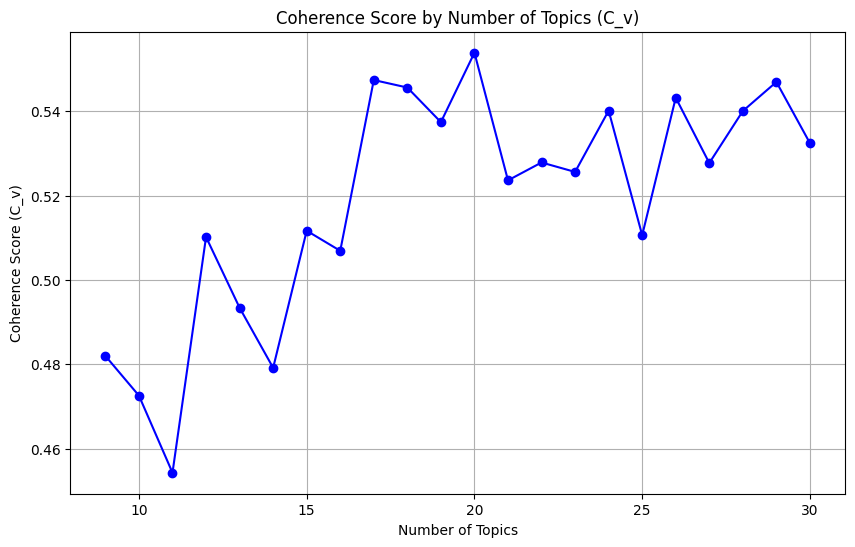

Training LDA with 9 topics (u_mass)...
Training LDA with 10 topics (u_mass)...
Training LDA with 11 topics (u_mass)...
Training LDA with 12 topics (u_mass)...
Training LDA with 13 topics (u_mass)...
Training LDA with 14 topics (u_mass)...
Training LDA with 15 topics (u_mass)...
Training LDA with 16 topics (u_mass)...
Training LDA with 17 topics (u_mass)...
Training LDA with 18 topics (u_mass)...
Training LDA with 19 topics (u_mass)...
Training LDA with 20 topics (u_mass)...
Training LDA with 21 topics (u_mass)...
Training LDA with 22 topics (u_mass)...
Training LDA with 23 topics (u_mass)...
Training LDA with 24 topics (u_mass)...
Training LDA with 25 topics (u_mass)...
Training LDA with 26 topics (u_mass)...
Training LDA with 27 topics (u_mass)...
Training LDA with 28 topics (u_mass)...
Training LDA with 29 topics (u_mass)...
Training LDA with 30 topics (u_mass)...


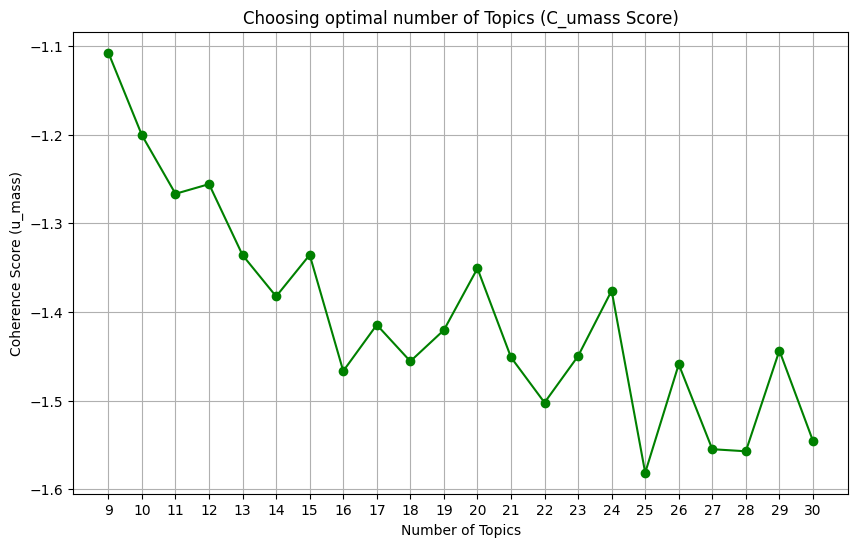

In [ ]:
import matplotlib.pyplot as plt

# Giả sử corpus_2020, id2word_2020, all_tokens đã có sẵn từ trước

# --- Đoạn 1: coherence C_v từ 3 đến 19 topics ---
topics_cv = []
score_cv = []

for i in range(9,31):
    print(f"Training LDA with {i} topics (C_v)...")
    lda_model = LdaMulticore(
        corpus=corpus_2020,
        id2word=id2word_2020,
        iterations=50,
        num_topics=i,
        workers=4,
        passes=10,
        random_state=100
    )
    cm = CoherenceModel(
        model=lda_model,
        texts=all_tokens_clean,
        corpus=corpus_2020,
        dictionary=id2word_2020,
        coherence='c_v'
    )
    topics_cv.append(i)
    score_cv.append(cm.get_coherence())

plt.figure(figsize=(10,6))
plt.plot(topics_cv, score_cv, marker='o', color='blue')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (C_v)')
plt.title('Coherence Score by Number of Topics (C_v)')
plt.grid(True)
plt.show()

# --- Đoạn 2: coherence u_mass từ 9 đến 29 topics ---
topics_umass = []
score_umass = []

for i in range(9, 31):
    print(f"Training LDA with {i} topics (u_mass)...")
    lda_model = LdaMulticore(
        corpus=corpus_2020,
        id2word=id2word_2020,
        num_topics=i,
        workers=4,
        passes=10,
        iterations=50,
        random_state=100
    )
    cm = CoherenceModel(
        model=lda_model,
        corpus=corpus_2020,
        dictionary=id2word_2020,
        coherence='u_mass'
    )
    topics_umass.append(i)
    score_umass.append(cm.get_coherence())

plt.figure(figsize=(10, 6))
plt.plot(topics_umass, score_umass, marker='o', color='green')
plt.title('Choosing optimal number of Topics (C_umass Score)')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (u_mass)')
plt.xticks(topics_umass)
plt.grid(True)
plt.show()

In [ ]:
# from gensim.models import CoherenceModel
# import matplotlib.pyplot as plt
# Your tokens are stored in "all_tokens" (collected from your monthly CSVs)
topics = []
score = []

for i in range(3, 16, 1):
    print(f"Training LDA with {i} topics...")
    # Train LDA model
    lda_model = LdaMulticore(
        corpus=corpus_2020,
        id2word=id2word_2020,
        iterations=50,        # 50 is better than 10 for stability
        num_topics=i,
        workers=4,
        passes=10,
        random_state=100
    )

    # Calculate coherence using C_v
    cm = CoherenceModel(
        model=lda_model,
        texts=all_tokens_clean,     # use your "all_tokens_clean" (list of list of tokens)
        corpus=corpus_2020,
        dictionary=id2word_2020,
        coherence='c_v'
    )
    topics.append(i)
    score.append(cm.get_coherence())

# Plotting
plt.figure(figsize=(10,6))
plt.plot(topics, score, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (C_v)')
plt.title('Coherence Score by Number of Topics')
plt.grid(True)
plt.show()

In [ ]:
lda_model_final_2020.show_topic(i, topn=1500)

[('kinh_tế', 0.01969816),
 ('trung_quốc', 0.0138265025),
 ('cổ_đông', 0.012797039),
 ('eximbank', 0.010708998),
 ('nền', 0.009251803),
 ('hđqt', 0.009100905),
 ('vốn', 0.008249482),
 ('tài_chính', 0.008106131),
 ('đại_hội', 0.0076735215),
 ('chính_sách', 0.0073514115),
 ('tiền_tệ', 0.0069299),
 ('tổ_chức', 0.006688449),
 ('tăng_trưởng', 0.0066810786),
 ('họp', 0.006539888),
 ('nhnn', 0.0064305146),
 ('covid', 0.0056389906),
 ('tác_động', 0.005461643),
 ('cắt_giảm', 0.0052815042),
 ('dịch_bệnh', 0.0049972436),
 ('thành_viên', 0.0049321265),
 ('lạm_phát', 0.0048532914),
 ('chủ_tịch', 0.004254093),
 ('ảnh_hưởng', 0.004082693),
 ('nới', 0.004005002),
 ('lãi_suất', 0.003988551),
 ('hỗ_trợ', 0.0039549605),
 ('dịch', 0.0037942086),
 ('thường_niên', 0.0037707235),
 ('khoản', 0.0037205317),
 ('lỏng', 0.0037119193),
 ('toàn_cầu', 0.00369717),
 ('giữ', 0.003679852),
 ('ngành', 0.0035486228),
 ('nhân_dân_tệ', 0.0035246215),
 ('nhà_nước', 0.003472099),
 ('vấn_đề', 0.0034390716),
 ('thứ', 0.00342726

In [ ]:
# Retrain the final model with 4 topics
lda_model_final_2020 = LdaMulticore(
    corpus=corpus_2020,
    id2word=id2word_2020,
    iterations=50,
    num_topics=20,
    workers=4,
    passes=10,
    random_state=100
)

# Save the final model
lda_model_final_2020.save('D:/hust/Fintech_topic/fintech_topic_vsc/2020_lda_model_20topics.model')
print("Final LDA model saved!")

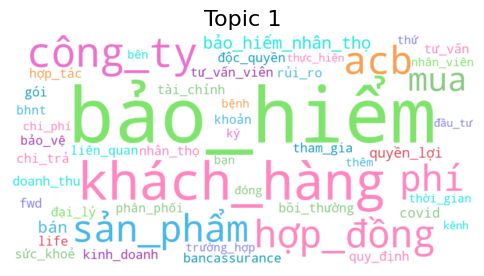

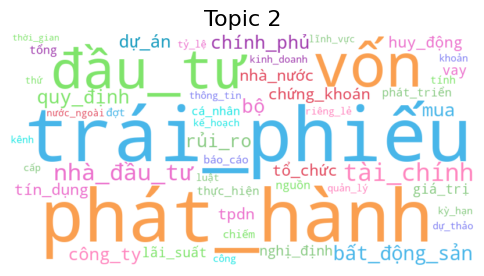

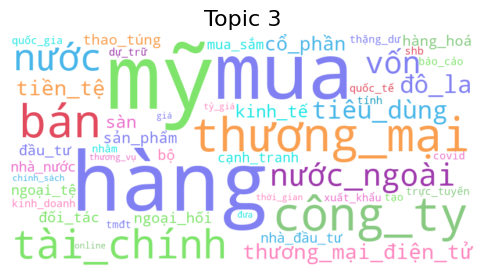

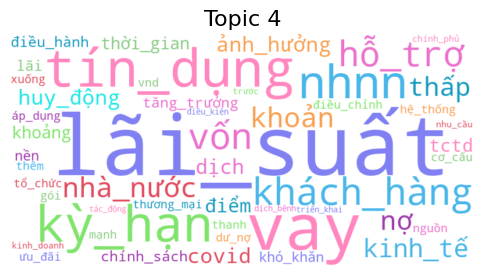

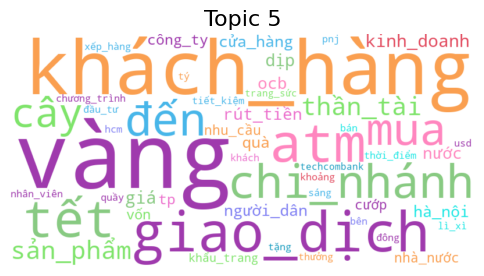

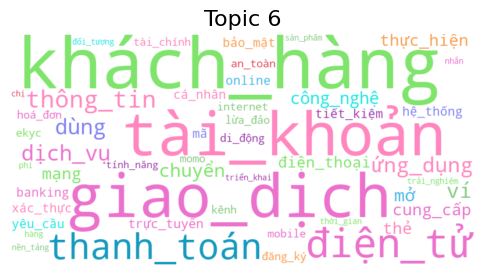

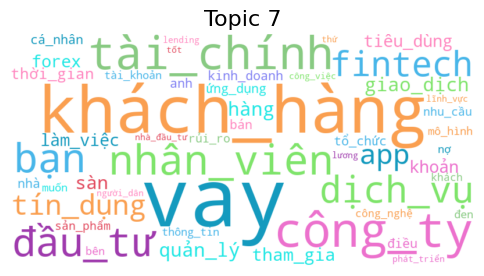

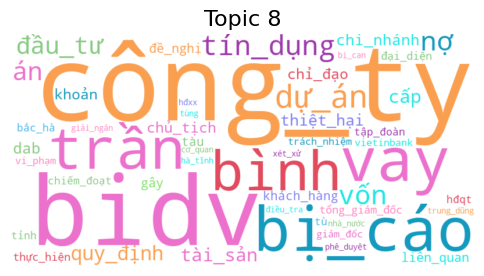

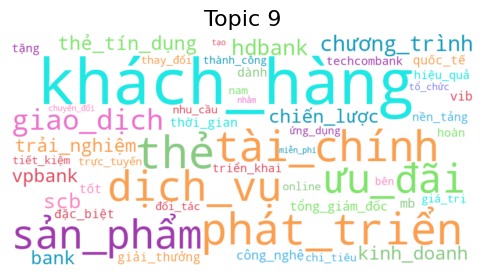

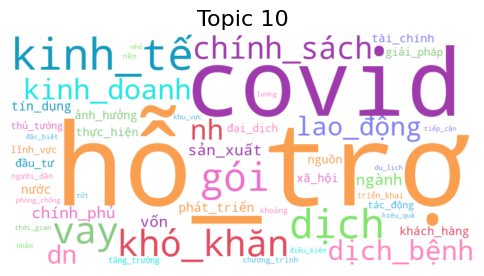

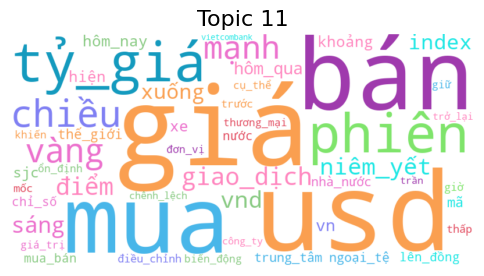

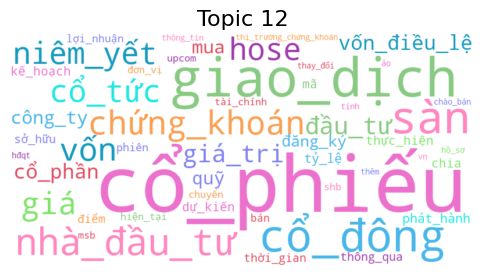

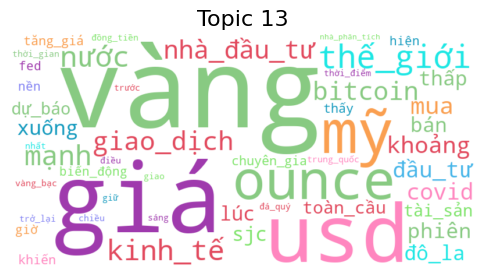

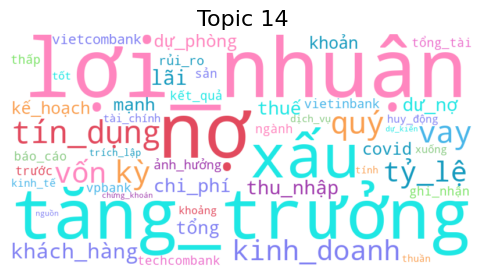

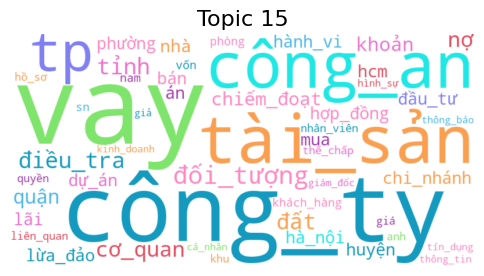

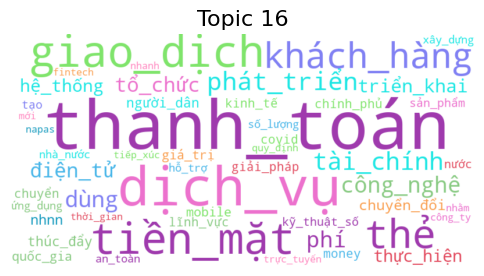

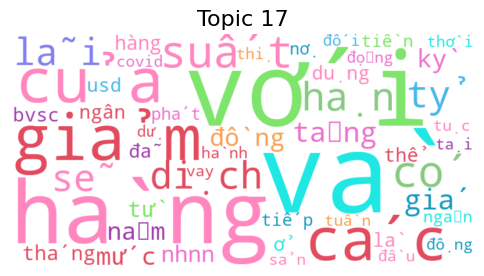

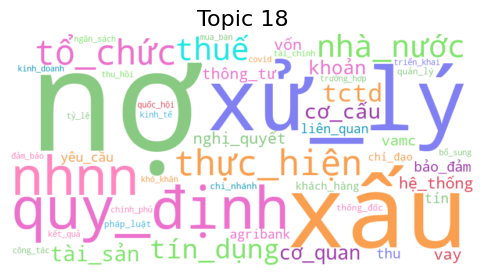

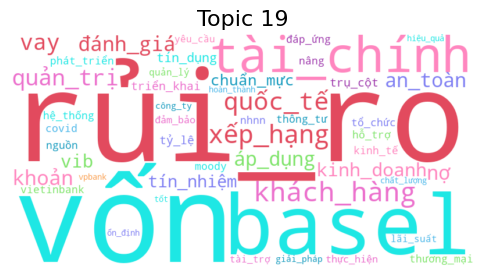

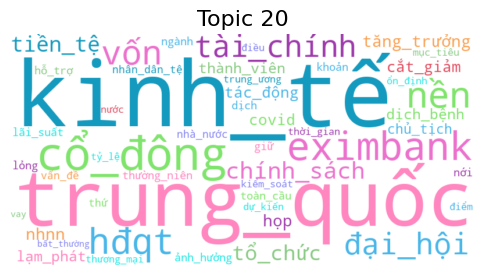

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
colors = [
    "#88CA82", "#9F3AADA9", "#FF86BF", "#8080F3", "#FA9F50",
    "#1EE7E4", "#E24A5E", "#EC71CDF0", "#48B6E9", "#149ABE", "#7FE46B"
]
num_topics = lda_model_final_2020.num_topics
def color_func_factory(color_list):
    def color_func(*args, **kwargs):
        return random.choice(color_list)
    return color_func

for i in range(num_topics):
    word_freqs = dict(lda_model_final_2020.show_topic(i, topn=50))
    wc = WordCloud(
        width=800, height=400,
        background_color='white',
        color_func=color_func_factory(colors),
        prefer_horizontal=1.0
    ).generate_from_frequencies(word_freqs)

    plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Topic {i+1}", fontsize=16)
    plt.axis('off')
    plt.show()

In [ ]:
# Show all words in topic 17 with their probabilities
topic_words = lda_model_final_2020.show_topic(16, topn=2000)  # Adjust `topn` if needed

# Print each word and its weight
for word, prob in topic_words:
    print(f"{word}: {prob:.4f}")

và: 0.0131
với: 0.0112
hàng: 0.0108
giảm: 0.0105
của: 0.0100
các: 0.0091
suất: 0.0087
có: 0.0085
hạn: 0.0070
dịch: 0.0070
tỷ: 0.0068
sẽ: 0.0067
lãi: 0.0066
tăng: 0.0065
giá: 0.0065
đồng: 0.0063
mức: 0.0063
kỳ: 0.0061
năm: 0.0057
từ: 0.0051
nhnn: 0.0048
tháng: 0.0046
hàng: 0.0044
là: 0.0043
ngân: 0.0042
đã: 0.0042
dụng: 0.0042
ở: 0.0041
bvsc: 0.0040
thể: 0.0040
usd: 0.0039
tiếp: 0.0038
tiền: 0.0038
phát: 0.0038
nợ: 0.0038
ngân: 0.0037
động: 0.0037
tục: 0.0035
động: 0.0035
đầu: 0.0035
thời: 0.0035
hành: 0.0035
dự: 0.0035
thị: 0.0034
tuần: 0.0034
covid: 0.0034
tại: 0.0034
sản: 0.0034
đối: 0.0033
vay: 0.0033
mạnh: 0.0033
tmđt: 0.0032
này: 0.0032
chính: 0.0031
tế: 0.0031
cũng: 0.0031
số: 0.0031
hoạt: 0.0030
lại: 0.0030
tới: 0.0030
để: 0.0030
bán: 0.0029
đến: 0.0029
tín: 0.0028
doanh: 0.0028
vốn: 0.0028
thanh: 0.0027
khoản: 0.0027
định: 0.0027
lớn: 0.0027
về: 0.0027
đó: 0.0027
nhất: 0.0027
vẫn: 0.0027
nhiều: 0.0026
tài: 0.0026


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Adjusted for your final model and objects
lda_display = gensimvis.prepare(
    lda_model_final_2020,    # your final LDA model (e.g., 8 topics)
    corpus_2020,             # your corpus
    id2word_2020             # your dictionary
)

pyLDAvis.display(lda_display)

In [ ]:
pyLDAvis.save_html(lda_display, 'D:/hust/Fintech_topic/fintech_topic_vsc/lda_2020_visualization.html')

In [ ]:
topic_distributions = []
for i, doc_bow in enumerate(corpus_2020):
    topic_probs = lda_model_final_2020.get_document_topics(doc_bow, minimum_probability=0)
    topic_percentages = [round(prob * 100, 2) for topic_id, prob in sorted(topic_probs)]
    topic_distributions.append(topic_percentages)

topic_columns = pd.DataFrame(
    topic_distributions,
    columns=[f'Topic_{i}_percent' for i in range(lda_model_final_2020.num_topics)]
)

# Concatenate with original dataframe
df = pd.concat([df, topic_columns], axis=1)

In [ ]:
output_file = "D:/hust/Fintech_topic/fintech_topic_vsc/news_2020_with_topics.csv"
df.to_csv(output_file, index=False, encoding="utf-8-sig")